In [12]:
import sys
COMP_NAME = "icecube-neutrinos-in-deep-ice"
sys.path.append(f"/home/anjum/kaggle/{COMP_NAME}/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from src.config import INPUT_PATH, OUTPUT_PATH

In [2]:
_dtype = {
    "batch_id": "int16",
    "event_id": "int64",
    "first_pulse_index": "int32",
    "last_pulse_index": "int32",
#     "azimuth": "float32",
#     "zenith": "float32",
}

meta = pd.read_parquet(
    INPUT_PATH / "train_meta.parquet",
    columns=["batch_id", "event_id", "first_pulse_index", "last_pulse_index"],
).astype(_dtype)
meta.shape

(131953924, 4)

In [3]:
meta["n_pulses"] = meta["last_pulse_index"] - meta["first_pulse_index"]
meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,n_pulses
0,1,24,0,60,60
1,1,41,61,111,50
2,1,59,112,147,35
3,1,67,148,289,141
4,1,72,290,351,61


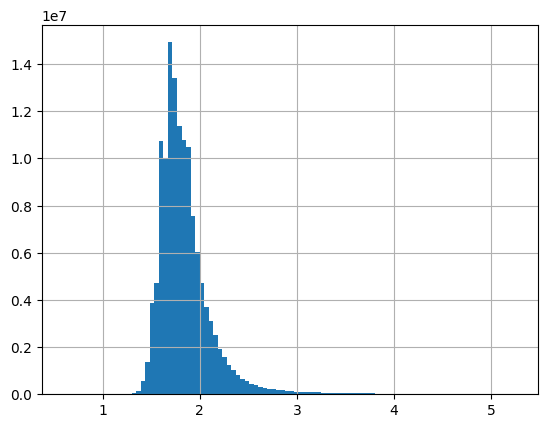

In [4]:
np.log10(meta["n_pulses"]).hist(bins=100);

In [8]:
meta["bins"] = pd.qcut(np.log10(meta["n_pulses"]), 10, labels=False)
meta["bins"].value_counts()

2    15116423
0    14728439
4    14278994
7    13608356
9    13145685
5    12949389
8    12755626
6    11848669
3    11792628
1    11729715
Name: bins, dtype: int64

In [11]:
meta[meta["bins"] == 0].describe()

,batch_id,event_id,first_pulse_index,last_pulse_index,n_pulses,bins
count,1.472844e+07,1.472844e+07,1.472844e+07,1.472844e+07,1.472844e+07,14728439.0
mean,3.304881e+02,1.074133e+09,1.643134e+07,1.643137e+07,3.459053e+01,0.0
std,1.904499e+02,6.199549e+08,9.505908e+06,9.505908e+06,3.791148e+00,0.0
min,1.000000e+00,5.900000e+01,0.000000e+00,2.700000e+01,4.000000e+00,0.0
25%,1.660000e+02,5.373846e+08,8.203042e+06,8.203078e+06,3.200000e+01,0.0
50%,3.310000e+02,1.074263e+09,1.641474e+07,1.641478e+07,3.500000e+01,0.0
75%,4.950000e+02,1.611023e+09,2.465016e+07,2.465019e+07,3.800000e+01,0.0
max,6.600000e+02,2.147484e+09,3.553526e+07,3.553530e+07,3.900000e+01,0.0


In [10]:
meta[meta["bins"] == 9].describe()

,batch_id,event_id,first_pulse_index,last_pulse_index,n_pulses,bins
count,1.314568e+07,1.314568e+07,1.314568e+07,1.314568e+07,1.314568e+07,13145685.0
mean,3.303840e+02,1.073794e+09,1.643946e+07,1.644052e+07,1.058705e+03,9.0
std,1.904588e+02,6.199845e+08,9.506023e+06,9.506024e+06,4.829572e+03,0.0
min,1.000000e+00,7.900000e+01,0.000000e+00,1.450000e+02,1.440000e+02,9.0
25%,1.650000e+02,5.367608e+08,8.211235e+06,8.212285e+06,1.700000e+02,9.0
50%,3.300000e+02,1.074026e+09,1.642743e+07,1.642844e+07,2.210000e+02,9.0
75%,4.950000e+02,1.610717e+09,2.466004e+07,2.466108e+07,3.920000e+02,9.0
max,6.600000e+02,2.147483e+09,3.553503e+07,3.553517e+07,1.782490e+05,9.0


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=48)
meta["fold"] = 0

for i, (train_index, test_index) in enumerate(skf.split(meta["event_id"], meta["bins"])):
    meta.loc[test_index, "fold"] = i

In [14]:
meta["fold"].value_counts()

2    26390785
0    26390785
3    26390785
1    26390785
4    26390784
Name: fold, dtype: int64

In [16]:
meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,n_pulses,bins,fold
0,1,24,0,60,60,4,2
1,1,41,61,111,50,2,0
2,1,59,112,147,35,0,4
3,1,67,148,289,141,8,3
4,1,72,290,351,61,4,1


In [18]:
meta[["batch_id", "event_id", "fold"]].to_parquet(INPUT_PATH / "folds.parquet")